In [1]:
H = 224
W = 224

In [2]:
# import os
# import random
# import shutil

# # Paths to the folders containing images and masks
# image_folder = 'kraggle_images/images'  # Folder with images
# mask_folder = 'kraggle_images/masks'    # Folder with masks

# # Destination folders for training and testing splits
# train_image_folder = 'kraggle_images/training/images'
# train_mask_folder = 'kraggle_images/training/masks'
# test_image_folder = 'kraggle_images/testing/images'
# test_mask_folder = 'kraggle_images/testing/masks'

# # Create destination folders if they don't exist
# os.makedirs(train_image_folder, exist_ok=True)
# os.makedirs(train_mask_folder, exist_ok=True)
# os.makedirs(test_image_folder, exist_ok=True)
# os.makedirs(test_mask_folder, exist_ok=True)

# # Get list of all images
# image_list = os.listdir(image_folder)
# mask_list = os.listdir(mask_folder)

# # Make sure images and masks are paired correctly
# image_list = sorted(image_list)
# mask_list = sorted(mask_list)

# # Split ratio for training and testing
# train_ratio = 0.8
# num_images = len(image_list)
# train_size = int(train_ratio * num_images)

# # Shuffle and split the data
# combined = list(zip(image_list, mask_list))
# random.shuffle(combined)

# train_data = combined[:train_size]
# test_data = combined[train_size:]

# # Helper function to copy files
# def copy_files(data, src_image_folder, src_mask_folder, dst_image_folder, dst_mask_folder):
#     for image_name, mask_name in data:
#         # Source paths
#         image_src = os.path.join(src_image_folder, image_name)
#         mask_src = os.path.join(src_mask_folder, mask_name)

#         # Destination paths
#         image_dst = os.path.join(dst_image_folder, image_name)
#         mask_dst = os.path.join(dst_mask_folder, mask_name)

#         # Copy image and mask to the respective folder
#         shutil.copy(image_src, image_dst)
#         shutil.copy(mask_src, mask_dst)

# # Copy training data
# copy_files(train_data, image_folder, mask_folder, train_image_folder, train_mask_folder)

# # Copy testing data
# copy_files(test_data, image_folder, mask_folder, test_image_folder, test_mask_folder)

# print(f'Training set size: {len(train_data)} images')
# print(f'Testing set size: {len(test_data)} images')


In [3]:
from collections import namedtuple
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Label = namedtuple( 'Label' , ['name' ,'id','color'] )
labels = [
    Label(  'ground'  ,  0 ,  (0,  0,  0)     ),
    Label(  'crack'   ,  1 ,  (255, 255, 255) )
]

max_label_id = max([l.id for l in labels])

# turn to arr of numbers between 0 to 1
LabelCmap = colors.ListedColormap([np.array(l.color) / 255 for l in labels])
bounds = np.linspace(0, max_label_id, len(labels))

def display(display_list):
  fig, cols = plt.subplots(1, len(display_list), sharey=True)
  fig.set_size_inches(15, 5)
  title = ['Input Image', 'Ground-truth Labels', 'Stage 1 Prediction Labels']
  im = None
  for i in range(len(display_list)):
    cols[i].set_title(title[i])
    y = display_list[i]
    
    if 'Label' in title[i]:
      w,h,_ = y.shape
      y = y.reshape(w,h)
      im = cols[i].imshow(y, cmap=LabelCmap, vmin=0, vmax=max_label_id)
    else:
      im = cols[i].imshow(tf.keras.preprocessing.image.array_to_img(y)) # this look better
      #im = cols[i].imshow(y)
    cols[i].axis('off')
  cbar = plt.colorbar(im, ax=cols.ravel().tolist(), cmap=LabelCmap, norm=colors.BoundaryNorm(bounds, LabelCmap.N), 
                      orientation='horizontal',spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
  cbar.ax.set_xticklabels([l.name for l in labels], rotation=90)
  plt.show()

# Plotting Loss, IoU, and Correct in separate subplots
def plot_metrics(mode, loss_history, iou_history, correct_history):
    # print(loss_history)
    # print(iou_history)
    # print(correct_history)
    epochs = range(1, len(loss_history) + 1)

    # Create subplots: 1 row, 3 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Loss
    ax1.plot(epochs, np.array(loss_history), color='tab:blue', label='Loss')
    ax1.set_title(f"{mode} Loss Over Epochs")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend()

    # Plot IoU
    #print(iou_history)
    ax2.plot(epochs, [iou.cpu().numpy() for iou in iou_history], color='tab:green', label='IoU')
    ax2.set_title(f"{mode} IoU Over Epochs")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend()

    # Plot Correct Predictions
    ax3.plot(epochs, np.array(correct_history), color='tab:red', label='Correct Predictions')
    ax3.set_title(f"{mode} Correct Predictions Over Epochs")
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Correct Predictions')
    ax3.tick_params(axis='y', labelcolor='tab:red')
    ax3.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()


In [4]:
from torchvision import transforms, datasets
import os
import os.path as osp
import random
from glob import glob
from PIL import Image
import scipy.io as scio
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import torch

class CrackDataSet(torch.utils.data.Dataset):
    # data[0] is image, data[1] is mask
    def __init__(self, data, data_transforms):
        self.data_transforms = data_transforms
        self.data = data
        
    def __len__(self):
        return len(self.data[0]) # images size
        
    def __getitem__(self, index):
        # OpenCV's default = BGR => RGB and then adding normalization here
        image = cv2.imread(self.data[0][index], cv2.IMREAD_COLOR)
        image = self.data_transforms(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'), 'RGB'))

        # masks are black and white images, so pixels closer to 255 consider = crack = label them
        mask = cv2.imread(self.data[1][index], cv2.IMREAD_GRAYSCALE)
        mask_label = np.zeros(mask.shape)
        mask_label[mask >= 128] = 1
        mask_label = np.asarray(mask_label, np.compat.long)
        mask_label = torch.LongTensor(mask_label)
        return image, mask_label

In [5]:
import argparse
import os
import time
import pandas as pd
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
from torchmetrics import JaccardIndex
import shutil
from torchvision import models
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

def load_data(path=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (valid_x, valid_y)

class Trainer_Wrapper():
    def __init__(self, model, input_path, batch_size, max_epochs, num_class=5):
        self.num_class = num_class
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.device = torch.device("cpu")
        self.batch_size = batch_size
        self.epoch = 1  # An epoch in machine learning is one complete pass through the entire training dataset during the training process
        self.max_epochs = max_epochs
        self.lr = 0.001  # Learning rate for the optimizer
        data_train, data_eval = load_data(path=input_path)
        self.image_datasets = {
            'train':
                CrackDataSet(data_train, data_transforms['train']),
            'validation':
                CrackDataSet(data_eval, data_transforms['validation'])
        }
        # create dataloader to read batch_size of items for training
        # when training, images should be choose random, so shuffle = True
        self.train_loader = torch.utils.data.DataLoader(self.image_datasets['train'],
                                                        batch_size=batch_size,
                                                        shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(self.image_datasets['validation'],
                                                      batch_size=batch_size,
                                                      shuffle=False)
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)  # gradient descent algorithm
        #self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

        # Intersection over Union (IoU): Measures the overlap between the predicted segmentation and the ground truth.
        self.fiou = JaccardIndex(task='multiclass', num_classes=self.num_class).to(self.device)
        self.loss_criterion = nn.CrossEntropyLoss()
        self.train_loss_history = []
        self.train_iou_history = []
        self.train_correct_history = []
        self.eval_loss_history = []
        self.eval_iou_history = []
        self.eval_correct_history = []

    def begin_train(self):
        start = self.epoch
        for self.epoch in range(start, self.max_epochs + 1):
            self.training()
            self.evaluating()

        plot_metrics("Training", self.train_loss_history, self.train_iou_history, self.train_correct_history)
        plot_metrics("Evaluating", self.eval_loss_history, self.eval_iou_history, self.eval_correct_history)

    def training(self):
        self.model.train()
        total_correct = 0
        # Wraps the DataLoader with tqdm for a progress bar during training.
        total_iou, total_loss, total_num_of_images, data_bar = 0.0, 0.0, 0.0, tqdm(self.train_loader)
        torch.enable_grad()  # Ensures that gradients are computed.
        num_of_batches = 0
        loss_arr, iou_arr, correct_arr  = [], [], []
        for data, target in data_bar:
            num_of_batches += 1
            data, target = data.to(self.device), target.to(self.device)

            # ensures that all CUDA operations on the GPU have completed
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()

            out = self.model(data)
            #out = out['out']

            # Converts the model's output logits to predicted class labels.
            # for example, tensor([[0.1, 2.5, 0.3],  # Sample 1 (class 1 has the highest score)
            #                     [1.2, 0.4, 3.0]]) # Sample 2 (class 2 has the highest score)
            # then calling argmax will get tensor([1, 2])
            prediction = torch.argmax(out, dim=1)

            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()

            # loss between the predictions and ground truth.
            loss = self.loss_criterion(out, target)

            num_of_samples = data.size(0)
            # quantifies the difference between the predicted output and the true values
            total_loss += loss.item() * num_of_samples
            # Calculates the Intersection over Union (IoU) for the predictions.
            total_iou += self.fiou(out.data.to(self.device), target.data.to(self.device))
            total_num_of_images += num_of_samples

            # the model parameters approach a local minimum in the loss landscape.
            # Reducing the learning rate helps the model make smaller, more precise updates, which can improve convergence to a minimum.
            self.lr = self.lr * 0.9997
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = self.lr
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # For example, if target has the shape [32, 256, 256] (for a batch of 32 images with 256x256 pixel labels, as in a segmentation task):
            # target.numel() would return 32 * 256 * 256 = 2,097,152, which is the total number of elements in the tensor.
            total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples
            # mPA = mean Pixel Accuracy
            
            avg_loss = total_loss / total_num_of_images
            avg_iou = total_iou / num_of_batches
            avg_correct = total_correct / total_num_of_images

            loss_arr.append(avg_loss)
            iou_arr.append(avg_iou)
            correct_arr.append(avg_correct)
            
            data_bar.set_description('Train epoch: [{}/{}] Loss: {:.4f} mPA: {:.2f}% IOU: {:.4f} '
                                     .format(self.epoch, self.max_epochs, avg_loss, avg_correct, avg_iou))

        self.train_loss_history.append(sum(loss_arr) / num_of_batches)
        self.train_iou_history.append(sum(iou_arr) / num_of_batches)
        self.train_correct_history.append(sum(correct_arr) / num_of_batches)

    def evaluating(self):
        self.model.eval() # enable eval mode
        torch.no_grad()
        total_iou, total_loss, total_correct, total_num_of_images, data_bar = 0.0, 0.0, 0.0, 0, tqdm(self.val_loader)
        num_of_batches = 0

        loss_arr, iou_arr, correct_arr  = [], [], []
        
        for data, target in data_bar:
            num_of_batches += 1
            data, target = data.to(self.device), target.to(self.device)
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()
            out = self.model(data)
            #out = out['out']

            prediction = torch.argmax(out, dim=1)
            if (self.device.type == 'cuda'):
                torch.cuda.synchronize()
            loss = self.loss_criterion(out, target)

            num_of_samples = data.size(0)
            total_loss += loss.item() * num_of_samples
            total_iou += self.fiou(out.data.to(self.device), target.data.to(self.device))
            total_num_of_images += num_of_samples
            total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples

            avg_loss = total_loss / total_num_of_images
            avg_iou = total_iou / num_of_batches
            avg_correct = total_correct / total_num_of_images

            loss_arr.append(avg_loss)
            iou_arr.append(avg_iou)
            correct_arr.append(avg_correct)
            
            data_bar.set_description('Eval epoch:  [{}/{}] Loss: {:.4f} mPA: {:.2f}% IOU: {:.4f} '
                                     .format(self.epoch, self.max_epochs, avg_loss, avg_correct, avg_iou))
            
        self.eval_loss_history.append(sum(loss_arr) / num_of_batches)
        self.eval_iou_history.append(sum(iou_arr) / num_of_batches)
        self.eval_correct_history.append(sum(correct_arr) / num_of_batches)
        
        #self.scheduler.step(sum(loss_arr) / num_of_batches)
        #self.random_val_predict()

    def random_val_predict(self, info=True, idx=0):
        if (idx == 0):
            idx = random.randint(0, len(self.image_datasets['validation']) - 1)

        rgb, mask = self.image_datasets['validation'][idx]
        # Suppose image is a tensor with shape [1, 3, 480, 640]:
        # 1 is the batch dimension (batch size of 1).
        # 3 is the number of color channels (RGB).
        # 480 and 640 are the height and width of the image.
        # squeeze(0): Removes the first dimension if its size is 1
        image = rgb.unsqueeze(0).to(self.device)
        mask = mask.unsqueeze(0).to(self.device)
        self.model.eval()
        with torch.no_grad():  # Disables gradient computation
            label = mask.cpu().numpy()  # convert a PyTorch tensor to a NumPy array and ensure it is on the CPU
            label = label.transpose(1, 2, 0)
            label = label.reshape(H, W, 1)

            img = image.squeeze(0)
            img = img.cpu().numpy()
            img = img.transpose(1, 2, 0)
            if img.shape[2] > 3:
                img = img[:, :, 0:3]

            outputs = self.model(image)
            #outputs = outputs['out']
            pred = torch.argmax(outputs, 1)  # Gets the predicted class labels.
            pred = pred.squeeze(0).cpu().data.numpy()

            display([img[:, :, 0:3], label, pred.reshape(H, W, 1)])
        return img, pred


In [6]:
""" RUN THIS BEFORE AND AFTER YOU TRAIN AND EVAL YOUR MODEL TO FREE UP MEM, OTHERWISE YOU'LL END UP OOM ERROR"""

import gc
gc.collect()
torch.cuda.empty_cache()

C:\Users\bigda\anaconda3\envs\py312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bigda\anaconda3\envs\py312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Train epoch: [1/200] Loss: 0.1502 mPA: 0.97% IOU: 0.4842 : 100%|█████████████████████| 226/226 [02:59<00:00,  1.26it/s]
Eval epoch:  [1/200] Loss: 0.1230 mPA: 0.97% IOU: 0.5485 : 100%|███████████████████████| 57/57 [00:32<00:00,  1.73it/s]
Train epoch: [2/200] Loss: 0.1093 mPA: 0.97% IOU: 0.5258 : 100%|█████████████████████| 226/226 [02:39<00:00,  1.42i

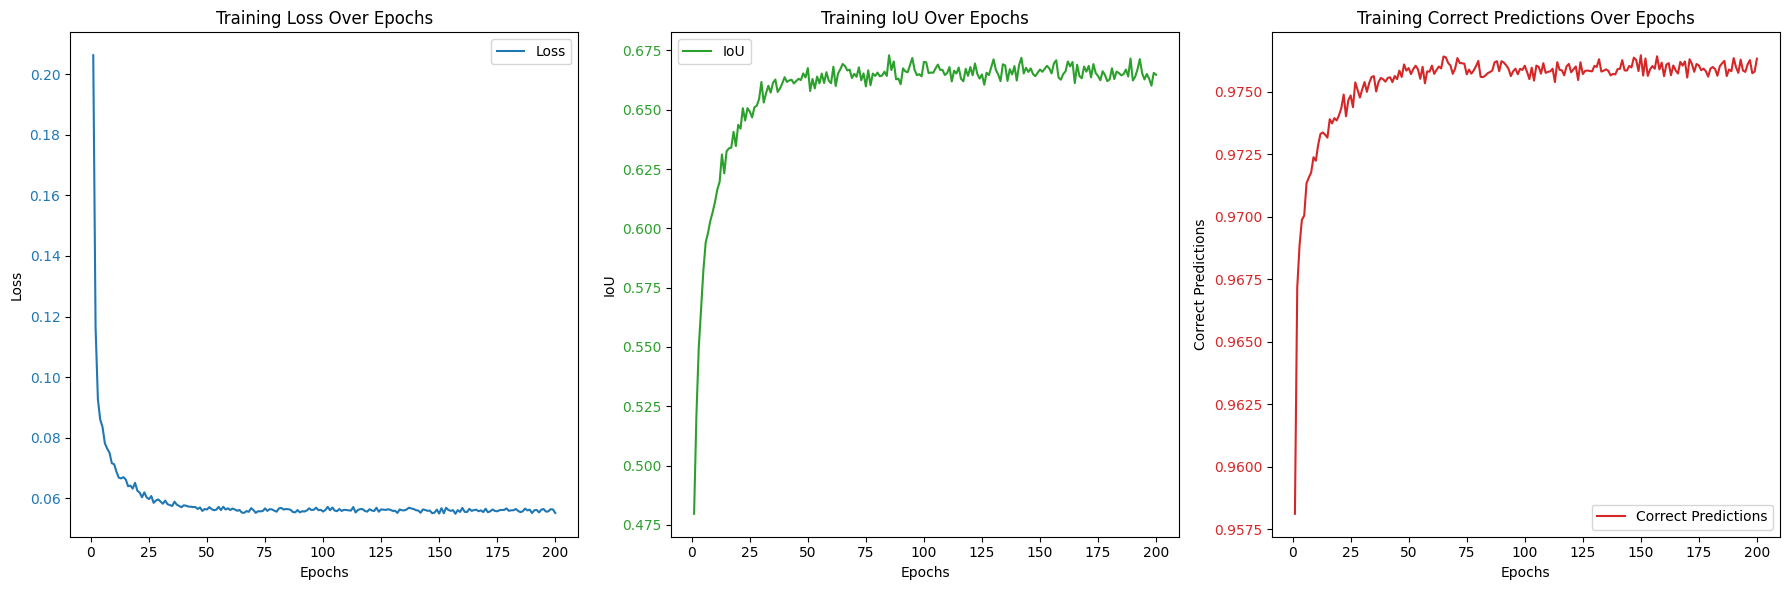

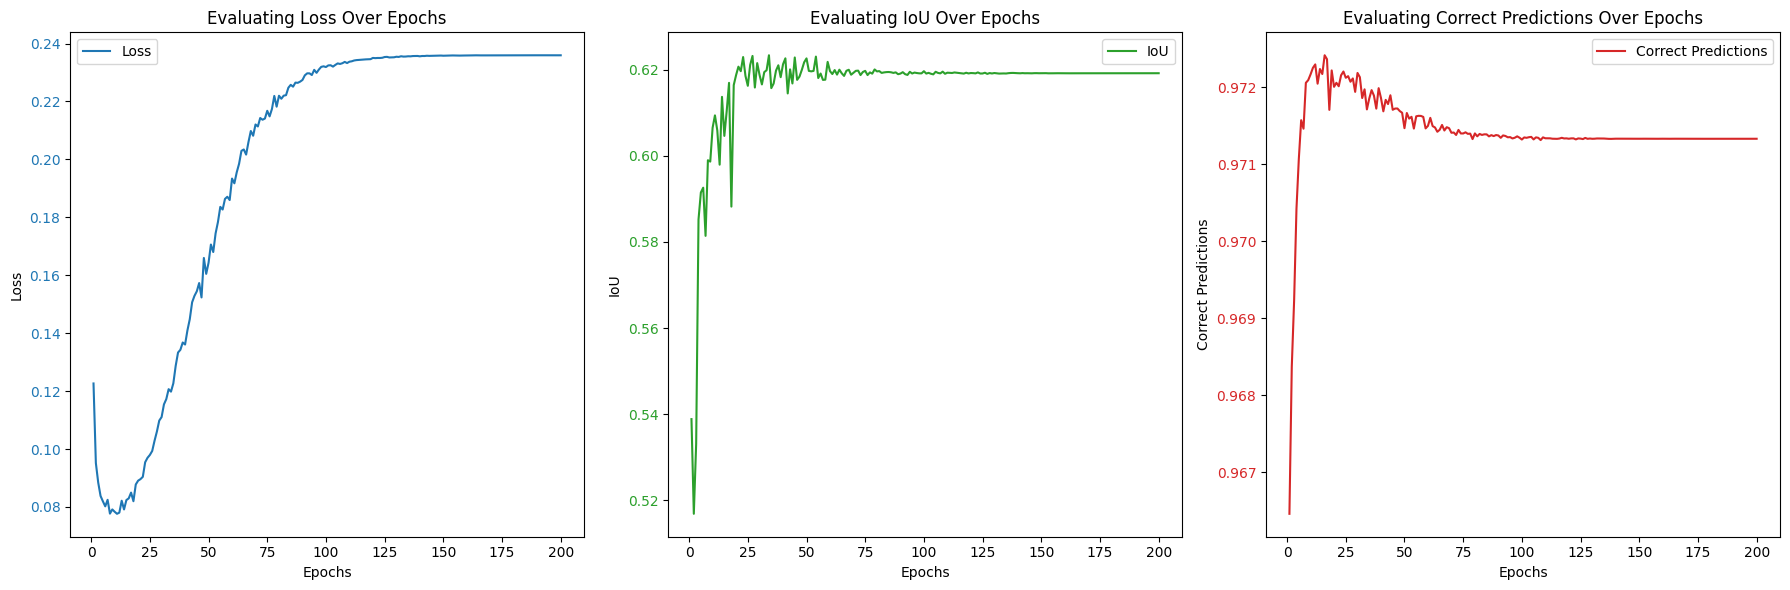

In [6]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models import vgg16

input_path = 'kraggle_images/vgg16'
#input_path = 'kraggle_images'
batch_size = 40 # Number of samples per batch during training
max_epochs = 200
num_of_classes = 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(), normalize]),
    'validation': transforms.Compose([transforms.ToTensor(), normalize]),
}

class VGG16Segmentation(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Segmentation, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.final_conv(x)  # Output channels matching num_classes
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        return x
        
# Initialize the model
model = VGG16Segmentation(num_of_classes)

trainer = Trainer_Wrapper(model, input_path, batch_size, max_epochs, num_of_classes)
trainer.begin_train()

weight_dir = input_path + "/weights"
filename = 'vgg16_best_weight.pth'
save_path = os.path.join(weight_dir, filename)
torch.save(trainer.model.state_dict(), save_path)

#trainer.random_val_predict()


In [1]:
import os
from PIL import Image

def resize_images_and_masks(image_dir, mask_dir, output_image_dir, output_mask_dir, new_size=(224, 224)):
    # Create output directories if they do not exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)

    # Get the list of images and masks
    image_filenames = os.listdir(image_dir)
    
    for filename in image_filenames:
        # Construct full file paths
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # Assuming masks have the same filename as images

        # Resize image
        with Image.open(image_path) as img:
            resized_image = img.resize(new_size, Image.BILINEAR)
            resized_image.save(os.path.join(output_image_dir, filename))

        # Resize mask
        with Image.open(mask_path) as mask:
            resized_mask = mask.resize(new_size, Image.BILINEAR)
            resized_mask.save(os.path.join(output_mask_dir, filename))

# Example usage
image_directory = 'kraggle_images/images'
mask_directory = 'kraggle_images/masks'
output_image_directory = 'kraggle_images/vgg16/images'
output_mask_directory = 'kraggle_images/vgg16/masks'

resize_images_and_masks(image_directory, mask_directory, output_image_directory, output_mask_directory)


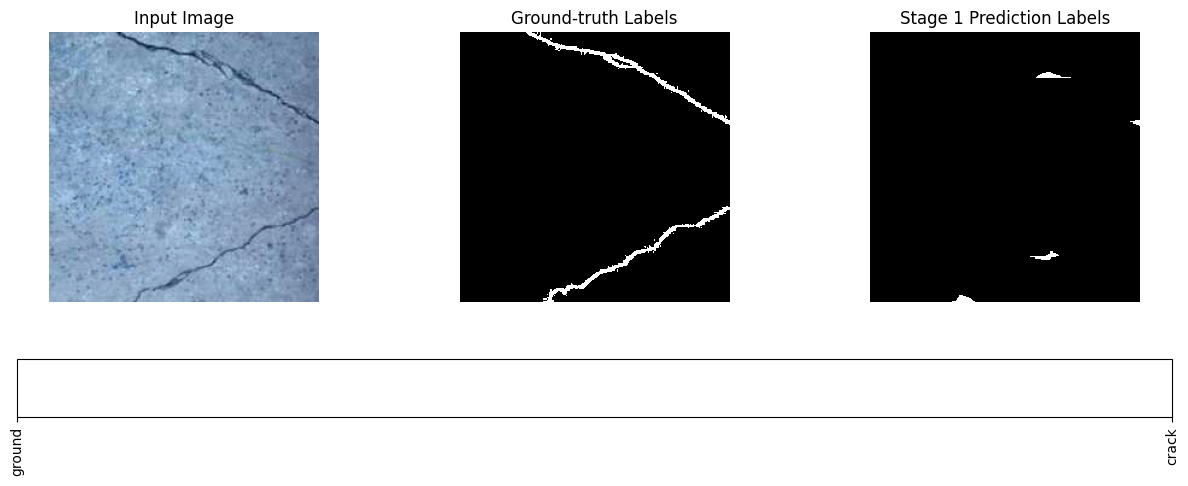

(array([[[-1.1075436 , -0.827731  , -0.5669716 ],
         [-1.1075436 , -0.827731  , -0.5669716 ],
         [-1.0904187 , -0.810224  , -0.54954237],
         ...,
         [-1.2102921 , -0.9677871 , -0.68897593],
         [-1.1760426 , -0.93277305, -0.6541175 ],
         [-1.1246684 , -0.880252  , -0.60182995]],
 
        [[-1.0390445 , -0.757703  , -0.49725482],
         [-1.0219197 , -0.740196  , -0.47982562],
         [-0.9876702 , -0.705182  , -0.44496724],
         ...,
         [-1.1760426 , -0.93277305, -0.6541175 ],
         [-1.1589178 , -0.91526604, -0.63668835],
         [-1.1246684 , -0.880252  , -0.60182995]],
 
        [[-0.9705454 , -0.687675  , -0.42753804],
         [-0.9362959 , -0.65266097, -0.39267966],
         [-0.88492167, -0.60014   , -0.34039208],
         ...,
         [-1.141793  , -0.897759  , -0.6192592 ],
         [-1.1246684 , -0.880252  , -0.60182995],
         [-1.1075436 , -0.862745  , -0.5844008 ]],
 
        ...,
 
        [[-0.6451751 , -0.39005598

In [11]:
trainer.random_val_predict()